Převod SAPCE NA PCE

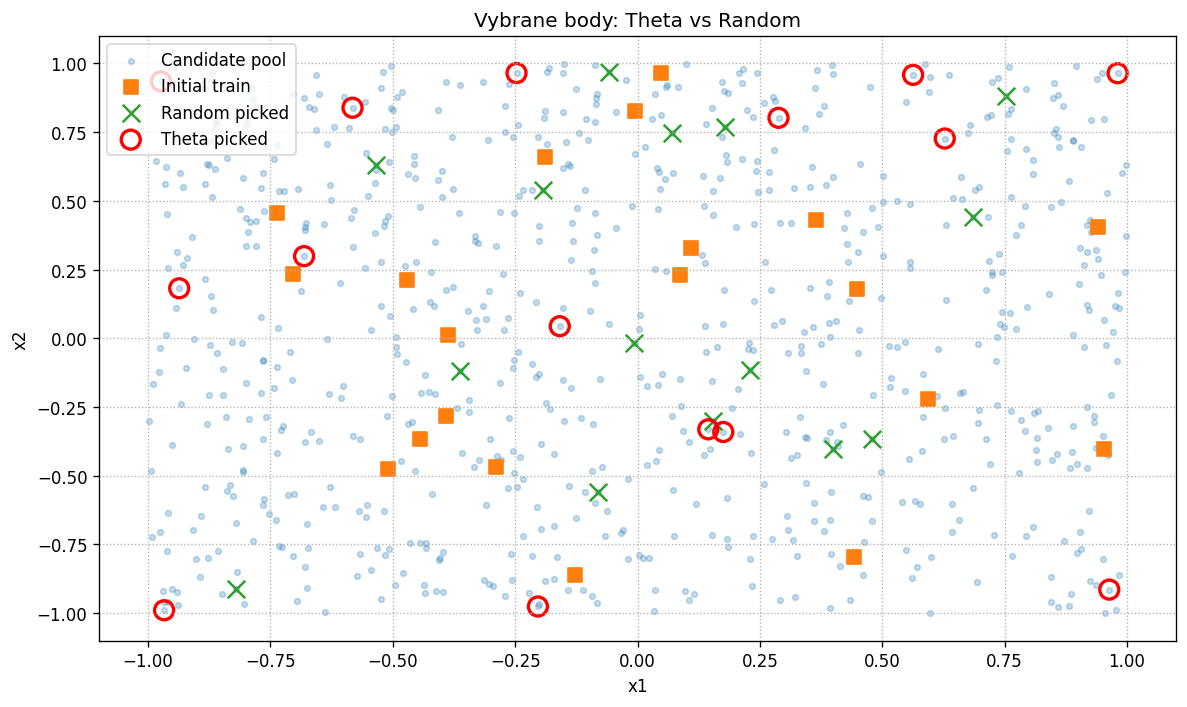


--- Fit status ---
Theta : OK (deg=4, cr=0.01)
Random: OK (deg=4, cr=0.01)

--- RMSE na test bodech ---
Theta RMSE : 0.010382510726895122
Random RMSE: 0.22492161649182785


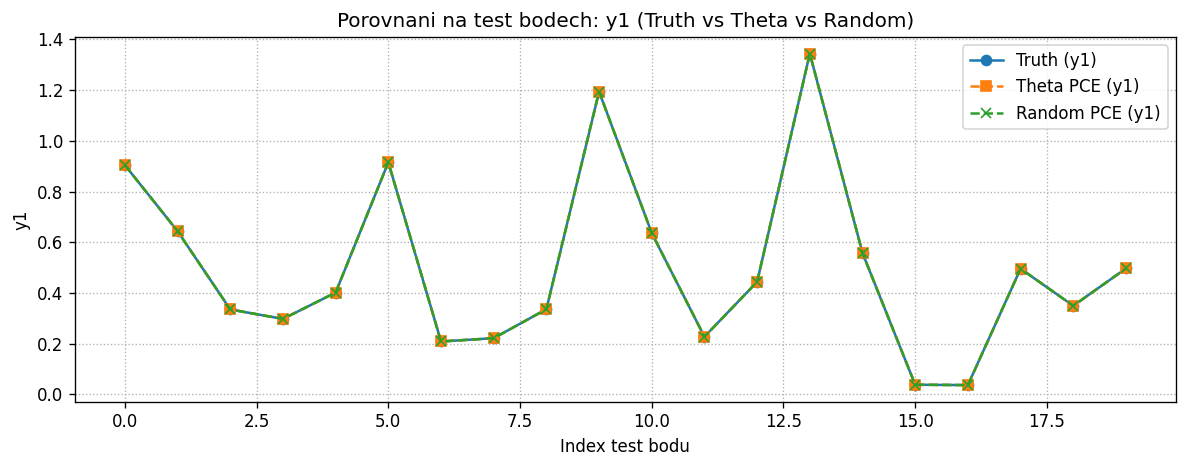

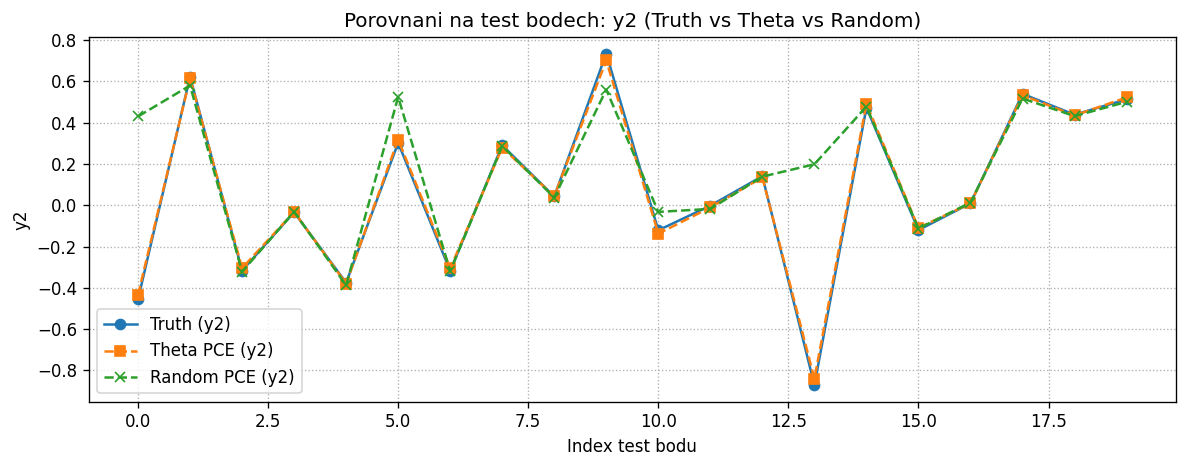

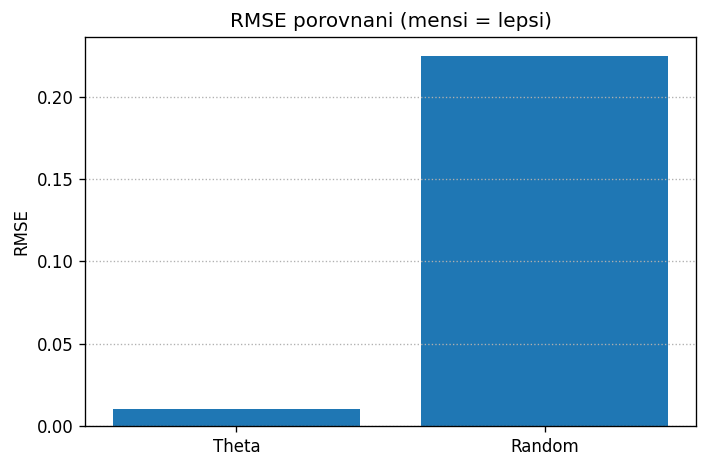

In [5]:

"""
Jednoduchy studentsky skript:
- Mame 2D vstup X = (x1, x2) a 2 vystupy (y1, y2).
- Vytvorime kandidatni pool bodu, z nej vybereme nove body:
    1) ThetaCriterionPCE (adaptivni vyber)  vs.  2) Random vyber
- Na konci porovname predikce (theta PCE vs random PCE) proti "pravde" na test bodech
  a vykreslime grafy: truth vs theta vs random.

Pozn.: Kod je psany schvalne jednoduse a "studentsky" (hodne komentaru).
"""

import io
import copy
import random
import contextlib

import numpy as np
import matplotlib.pyplot as plt

from UQpy.distributions import Uniform, JointIndependent
from UQpy.sampling import ThetaCriterionPCE

import SAPCE


# ============================================================
# 1) ZAKLADNI NASTAVENI (nahoda, rozdeleni, "pravdivy" model)
# ============================================================
np.random.seed(0)
random.seed(0)

# 2 nezavisle uniformni vstupy na intervalu [-1, 1]
joint = JointIndependent(marginals=[
    Uniform(loc=-1, scale=2),
    Uniform(loc=-1, scale=2)
])

def truth_model(X: np.ndarray) -> np.ndarray:
    """
    "Pravda" = simulace / model, ktery chceme aproximovat.
    Vstup:  X ... tvar (N, 2)
    Vystup: Y ... tvar (N, 2), kde [y1, y2]
    """
    x1 = X[:, 0]
    x2 = X[:, 1]
    y1 = x1**2 + 0.5 * x2**2
    y2 = x1 * x2 + 0.2 * np.sin(3.0 * x1)
    return np.column_stack([y1, y2])


# ============================================================
# 2) DATA: kandidatni pool + pocatecni trenovaci design
# ============================================================
# Kandidatni "mrizka" (nahodna mnozina bodu) ze ktere budeme vybirat
X_pool = joint.rvs(nsamples=800)

# Pocatecni trenovaci body (aby PCE vubec mohl zacit)
init_size = 20
idx_init = np.random.choice(np.arange(X_pool.shape[0]), size=init_size, replace=False)

X_train = X_pool[idx_init]
Y_train = truth_model(X_train)

# Kandidati = pool bez pocatecnich bodu (abychom je nevybrali znovu)
mask = np.ones(X_pool.shape[0], dtype=bool)
mask[idx_init] = False

X_cand_theta = X_pool[mask].copy()
X_cand_rand  = X_pool[mask].copy()


# ============================================================
# 3) SAPCE: fit + rozdeleni multi-output PCE na seznam 1-output PCE
# ============================================================
def fit_sapce(Xtr: np.ndarray, Ytr: np.ndarray, deg: int = 4, cr: float = 0.01):
    """
    Fit SAPCE (SensitivityAdaptivePCE).
    - deg = maximalni parcialni stupen
    - cr  = criterion pro prun (mensi -> prisnejsi)
    """
    sapce = SAPCE.SensitivityAdaptivePCE(
        pdf=joint,
        exp_design_in=Xtr,
        exp_design_out=Ytr,
        max_partial_degree=deg,
        num_inputs=2
    )

    # SAPCE casto dost printi do konzole, tak to potlacime (aby byl vystup cisty)
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        sapce.construct_adaptive_basis(max_condition_number=1e6)
        sapce.construct_pruned_pce(cr=cr)

    return sapce


def split_sapce_pce_to_list(pce_multi):
    """
    SAPCE obvykle vraci jednu PCE se 2 vystupy (koeficienty ve sloupcich).
    ThetaCriterionPCE v UQpy casto chce seznam PCE, kazda pro 1 vystup.
    """
    C = np.asarray(pce_multi.coefficients)
    if C.ndim == 1:
        C = C.reshape(-1, 1)

    out_list = []
    for j in range(C.shape[1]):
        pj = copy.deepcopy(pce_multi)
        pj.coefficients = C[:, j].reshape(-1, 1)  # jen jeden vystup
        out_list.append(pj)
    return out_list


def fit_sapce_safe(Xtr: np.ndarray, Ytr: np.ndarray, deg: int = 4, cr: float = 0.01):
    """
    Studentska "pojistka": nekdy SAPCE spadne (numerika, condition number, ...).
    Tak zkusime par jednodussich nastaveni.
    """
    attempts = [
        (deg, cr),
        (max(1, deg - 1), cr),
        (max(1, deg - 2), cr),
        (max(1, deg - 3), min(0.05, cr * 5.0)),
        (max(1, deg - 3), min(0.10, cr * 10.0)),
    ]

    last_err = None
    for d, c in attempts:
        try:
            sapce = SAPCE.SensitivityAdaptivePCE(
                pdf=joint,
                exp_design_in=Xtr,
                exp_design_out=Ytr,
                max_partial_degree=d,
                num_inputs=2
            )
            with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
                # nekdy failne uz adaptive basis, tak aspon zkusime prun
                try:
                    sapce.construct_adaptive_basis(max_condition_number=1e6)
                except Exception:
                    pass
                sapce.construct_pruned_pce(cr=c)

            return sapce, d, c, None

        except Exception as e:
            last_err = e

    return None, None, None, last_err


def _predict_one_pce(pce_obj, X: np.ndarray) -> np.ndarray:
    """
    Predikce PCE objektu: ruzne implementace mohou mit ruzne metody.
    Zkusime par beznych jmen metod.
    """
    for m in ("predict", "evaluate", "__call__", "run"):
        if hasattr(pce_obj, m):
            fn = getattr(pce_obj, m)
            try:
                y = np.asarray(fn(X))
                if y.ndim == 1:
                    y = y.reshape(-1, 1)
                return y
            except Exception:
                pass
    raise RuntimeError("Nejde predikovat z PCE (nenasel jsem funkci predict/evaluate/call/run).")


def predict_with_pce_list(pce_list, X: np.ndarray) -> np.ndarray:
    """
    Seznam PCE (kazda 1-output) -> slozime vysledky do (N, n_out).
    """
    cols = []
    for pj in pce_list:
        yj = _predict_one_pce(pj, X)
        if yj.shape[1] != 1:
            yj = yj.reshape(-1, 1)
        cols.append(yj)
    return np.hstack(cols)


# ============================================================
# 4) VYBER BODU: Theta vs Random
# ============================================================
K = 15  # kolik novych bodu vybrat

# ---------------- Theta selection (iterativne) ----------------
theta_selected = []

Xtr_theta = X_train.copy()
Ytr_theta = Y_train.copy()

# kdyby posledni refit spadl, chceme mit aspon posledni uspesnou PCE
last_pce_list_theta = None

for k in range(K):
    # 1) fit surrogate (SAPCE) na aktualnich datech
    try:
        sapce = fit_sapce(Xtr_theta, Ytr_theta, deg=4, cr=0.01)
        pce_list = split_sapce_pce_to_list(sapce.pce)
        last_pce_list_theta = pce_list
    except Exception:
        # fallback: kdyz to spadne, tak proste vezmeme nahodny bod
        pos = np.random.randint(0, X_cand_theta.shape[0])
        x_new = X_cand_theta[pos]
        y_new = truth_model(x_new.reshape(1, -1))

        theta_selected.append(x_new)
        Xtr_theta = np.vstack([Xtr_theta, x_new])
        Ytr_theta = np.vstack([Ytr_theta, y_new])

        X_cand_theta = np.delete(X_cand_theta, pos, axis=0)
        continue

    # 2) Theta criterion: vrati index kandidata, ktery je "nejlepsi" dle kriterie
    theta = ThetaCriterionPCE(pce_list)
    pos = int(theta.run(Xtr_theta, X_cand_theta))

    # pojistka na rozsah
    if pos < 0 or pos >= X_cand_theta.shape[0]:
        pos = np.random.randint(0, X_cand_theta.shape[0])

    # 3) pridame bod do treninku a odebereme z kandidatu
    x_new = X_cand_theta[pos]
    y_new = truth_model(x_new.reshape(1, -1))

    theta_selected.append(x_new)
    Xtr_theta = np.vstack([Xtr_theta, x_new])
    Ytr_theta = np.vstack([Ytr_theta, y_new])

    X_cand_theta = np.delete(X_cand_theta, pos, axis=0)

theta_selected = np.array(theta_selected)

# ---------------- Random selection ----------------
rand_idx = np.random.choice(np.arange(X_cand_rand.shape[0]), size=K, replace=False)
rand_selected = X_cand_rand[rand_idx]


# ============================================================
# 5) RYCHLY PLOT: kde lezi vybrane body (jen kontrola)
# ============================================================
plt.figure(figsize=(10, 6), dpi=120)
plt.scatter(X_pool[:, 0], X_pool[:, 1], s=12, alpha=0.25, label="Candidate pool")
plt.scatter(X_train[:, 0], X_train[:, 1], s=70, marker="s", label="Initial train")

plt.scatter(rand_selected[:, 0], rand_selected[:, 1], s=110, marker="x", label="Random picked")
plt.scatter(theta_selected[:, 0], theta_selected[:, 1], s=130,
            facecolors="none", edgecolors="red", linewidth=2, marker="o", label="Theta picked")

plt.title("Vybrane body: Theta vs Random")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


# ============================================================
# 6) FINAL: fit PCE pro THETA a pro RANDOM, test + graf porovnani
# ============================================================
# Random trenink = puvodni train + random vybrane body
Y_rand = truth_model(rand_selected)
Xtr_rand = np.vstack([X_train, rand_selected])
Ytr_rand = np.vstack([Y_train, Y_rand])

# --- Theta final fit (safe) ---
sapce_theta_final, d_th, c_th, err_th = fit_sapce_safe(Xtr_theta, Ytr_theta, deg=4, cr=0.01)
if sapce_theta_final is not None:
    pce_list_theta_final = split_sapce_pce_to_list(sapce_theta_final.pce)
    theta_fit_info = f"OK (deg={d_th}, cr={c_th})"
else:
    # fallback: vezmeme posledni uspesnou PCE z iteraci
    if last_pce_list_theta is None:
        raise RuntimeError(f"Theta: SAPCE selhal a nemam zadnou posledni PCE. Chyba: {err_th}")
    pce_list_theta_final = last_pce_list_theta
    theta_fit_info = f"FAIL -> pouzita posledni PCE z iteraci (chyba: {type(err_th).__name__})"

# --- Random final fit (safe) ---
sapce_rand_final, d_ra, c_ra, err_ra = fit_sapce_safe(Xtr_rand, Ytr_rand, deg=4, cr=0.01)
if sapce_rand_final is not None:
    pce_list_rand_final = split_sapce_pce_to_list(sapce_rand_final.pce)
    rand_fit_info = f"OK (deg={d_ra}, cr={c_ra})"
else:
    # posledni zachrana: fit jen na initial train (aby to aspon neco vykreslilo)
    sapce_rand_fallback, d_rf, c_rf, err_rf = fit_sapce_safe(X_train, Y_train, deg=4, cr=0.01)
    if sapce_rand_fallback is None:
        raise RuntimeError(f"Random: SAPCE selhal uplne. Chyba: {err_ra}")
    pce_list_rand_final = split_sapce_pce_to_list(sapce_rand_fallback.pce)
    rand_fit_info = f"FAIL -> fallback jen na initial train (deg={d_rf}, cr={c_rf})"

print("\n--- Fit status ---")
print("Theta :", theta_fit_info)
print("Random:", rand_fit_info)

# --- test body ---
n_test = 20
X_test = joint.rvs(nsamples=n_test)

Y_true = truth_model(X_test)
Y_pred_theta = predict_with_pce_list(pce_list_theta_final, X_test)
Y_pred_rand  = predict_with_pce_list(pce_list_rand_final,  X_test)

# RMSE pres oba vystupy dohromady (jedna hodnota)
rmse_theta = float(np.sqrt(np.mean((Y_pred_theta - Y_true) ** 2)))
rmse_rand  = float(np.sqrt(np.mean((Y_pred_rand  - Y_true) ** 2)))

print("\n--- RMSE na test bodech ---")
print("Theta RMSE :", rmse_theta)
print("Random RMSE:", rmse_rand)


# ============================================================
# 7) GRAFY NA KONCI: truth vs theta vs random
#    (jednoduse podle indexu test bodu, zvlast pro y1 a y2)
# ============================================================
idx = np.arange(n_test)

# --- y1 graf ---
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(idx, Y_true[:, 0], marker="o", linestyle="-", label="Truth (y1)")
plt.plot(idx, Y_pred_theta[:, 0], marker="s", linestyle="--", label="Theta PCE (y1)")
plt.plot(idx, Y_pred_rand[:, 0], marker="x", linestyle="--", label="Random PCE (y1)")
plt.title("Porovnani na test bodech: y1 (Truth vs Theta vs Random)")
plt.xlabel("Index test bodu")
plt.ylabel("y1")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# --- y2 graf ---
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(idx, Y_true[:, 1], marker="o", linestyle="-", label="Truth (y2)")
plt.plot(idx, Y_pred_theta[:, 1], marker="s", linestyle="--", label="Theta PCE (y2)")
plt.plot(idx, Y_pred_rand[:, 1], marker="x", linestyle="--", label="Random PCE (y2)")
plt.title("Porovnani na test bodech: y2 (Truth vs Theta vs Random)")
plt.xlabel("Index test bodu")
plt.ylabel("y2")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# --- bonus: sloupcovy graf RMSE (rychla metrika) ---
plt.figure(figsize=(6, 4), dpi=120)
plt.bar(["Theta", "Random"], [rmse_theta, rmse_rand])
plt.title("RMSE porovnani (mensi = lepsi)")
plt.ylabel("RMSE")
plt.grid(True, axis="y", linestyle=":")
plt.tight_layout()
plt.show()
